# **SETUP**

1) continue Image Classification problem from previous class which aims to classify microscopy images into good, empty or blurred by: 
1. gathering ~1000 samples per class for training the model; 
2. using https://supervise.ly for image augmentation to generate more samples;
3. using CNN and transfer learning

2) denoise blurred images using auto-encoder
1. please see https://blog.keras.io/building-autoencoders-in-keras.html
2. Simple structure could be: blurry input images -> feed into CNN (this could be transfer learning) -> train x - noise image  y - clean image -> Fully connected NN -> reconstructed clean image

3) track patches from fluorescence images and use a visualization tool


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
from platform import python_version

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.5'

In [3]:
tf.__version__

'1.15.2'

In [4]:
print(python_version())

3.6.9


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import backend as K

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/My Drive/DeepLearning/Project/dataset1/

!ls

/content/drive/My Drive/DeepLearning/Project/dataset1
'autoencoder model'   blurred2	 good	 test	 train1   VGG16_model1.h5
 blurred	      empty	 good2	 train	 val


In [0]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
# Where to save the figures
PROJECT_ROOT_DIR = "."
import os
import numpy as np
import shutil

In [0]:
 # Creating Train / Val / Test folders (One time use)
images_split = "/content/drive/My Drive/DeepLearning/Project/dataset1"
good = "/good"
empty = "/empty"
blurred = "/blurred"

if os.path.exists(images_split +'/train' + good):
    shutil.rmtree(images_split +'/train' + good)
os.makedirs(images_split +'/train' + good)

if os.path.exists(images_split +'/train1' + good):
    shutil.rmtree(images_split +'/train1' + good)
os.makedirs(images_split +'/train1' + good)

if os.path.exists(images_split +'/test' + good):
    shutil.rmtree(images_split +'/test' + good)
os.makedirs(images_split +'/test' + good)

if os.path.exists(images_split +'/val' + good):
    shutil.rmtree(images_split +'/val' + good)
os.makedirs(images_split +'/val' + good)

if os.path.exists(images_split +'/train' + empty):
    shutil.rmtree(images_split +'/train' + empty)
os.makedirs(images_split +'/train' + empty)

if os.path.exists(images_split +'/train1' + empty):
    shutil.rmtree(images_split +'/train1' + empty)
os.makedirs(images_split +'/train1' + empty)

if os.path.exists(images_split +'/test' + empty):
    shutil.rmtree(images_split +'/test' + empty)
os.makedirs(images_split +'/test' + empty)

if os.path.exists(images_split +'/val' + empty):
    shutil.rmtree(images_split +'/val' + empty)
os.makedirs(images_split +'/val' + empty)

if os.path.exists(images_split +'/train' + blurred):
    shutil.rmtree(images_split +'/train' + blurred)
os.makedirs(images_split +'/train' + blurred)

if os.path.exists(images_split +'/train1' + blurred):
    shutil.rmtree(images_split +'/train1' + blurred)
os.makedirs(images_split +'/train1' + blurred)


if os.path.exists(images_split +'/test' + blurred):
    shutil.rmtree(images_split +'/test' + blurred)
os.makedirs(images_split +'/test' + blurred)

if os.path.exists(images_split +'/val' + blurred):
    shutil.rmtree(images_split +'/val' + blurred)
os.makedirs(images_split +'/val' + blurred)


In [0]:
# Creating partitions of the data after shuffeling
sra = "/content/drive/My Drive/DeepLearning/Project/dataset1/good"
srb = "/content/drive/My Drive/DeepLearning/Project/dataset1/empty"
src = "/content/drive/My Drive/DeepLearning/Project/dataset1/blurred"

srx = "/content/drive/My Drive/DeepLearning/Project/dataset1/train/good"
sry = "/content/drive/My Drive/DeepLearning/Project/dataset1/train/empty"
srz = "/content/drive/My Drive/DeepLearning/Project/dataset1/train/blurred"

In [0]:
#Good train_test split
allFileNames = os.listdir(sra)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [sra+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [sra+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train/good")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/test/good")

In [0]:
#Good train_val split
allFileNames = os.listdir(srx)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [srx+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [srx+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Validating: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/good")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/val/good")

In [0]:
#Empty train_test split
allFileNames = os.listdir(srb)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [srb+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [srb+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train/empty")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/test/empty")

In [0]:
#Empty train_val split
allFileNames = os.listdir(sry)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [sry+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [sry+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Validating: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/empty")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/val/empty")

In [0]:
#Blurred train_test split
allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train/blurred")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/test/blurred")

In [0]:
#Blurred train_val split
allFileNames = os.listdir(srz)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [srz+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [srz+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Validating: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/blurred")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/val/blurred")

In [10]:
#Resize images to 224 x 224
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/"
validation_dir = "/content/drive/My Drive/DeepLearning/Project/dataset1/val/"
test_dir = "/content/drive/My Drive/DeepLearning/Project/dataset1/test/"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 3956 images belonging to 3 classes.
Found 1318 images belonging to 3 classes.
Found 1758 images belonging to 3 classes.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Input
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense,Flatten,Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
image_w, image_h = 224,224
model = Sequential()
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

last = model.output
x = Flatten()(last)
x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(model.input, preds)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [14]:
for layer in model.layers:
  layer.trainable = True
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_2 True
20 new_fc1 True
21 dropout_2 True
22 dense_2 True


In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_acc', verbose=2, patience=25)
filepath = "./VGG16_model1.h5"
mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

In [0]:
VGG16_model = model.fit(train_generator, validation_data = validation_generator, epochs = 30, verbose=2, callbacks=[es,mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
 - 1743s - loss: 3.4897 - acc: 0.6268 - val_loss: 1.9970 - val_acc: 0.7178

Epoch 00001: val_acc improved from -inf to 0.71775, saving model to ./VGG16_model1.h5
Epoch 2/30
 - 70s - loss: 1.5960 - acc: 0.7093 - val_loss: 1.3750 - val_acc: 0.6047

Epoch 00002: val_acc did not improve from 0.71775
Epoch 3/30
 - 70s - loss: 1.1638 - acc: 0.7496 - val_loss: 1.0277 - val_acc: 0.7580

Epoch 00003: val_acc improved from 0.71775 to 0.75797, saving model to ./VGG16_model1.h5
Epoch 4/30
 - 70s - loss: 0.9483 - acc: 0.7845 - val_loss: 0.8614 - val_acc: 0.7800

Epoch 00004: val_acc improved from 0.75797 to 0.77997, saving model to ./VGG16_model1.h5
Epoch 5/30
 - 70s - loss: 0.7787 - acc: 0.8251 - val_loss: 0.7530 - val_acc: 0.7822

Epoch 00005: val_acc improved from 0.77997 to 0.78225, saving model to ./VGG16_model1.h5
Epoch 6/30
 - 70s - loss: 0.6368 - acc: 0.8601 - val_loss: 0.8151 - val_ac

# **Evaluate Model**

In [17]:
from keras.models import load_model
import numpy
import os

%cd /content/drive/My Drive/DeepLearning/Project/dataset1

/content/drive/My Drive/DeepLearning/Project/dataset1


In [18]:
final_model_VGG16 = tf.keras.models.load_model('./VGG16_model1.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
# evaluate the model on validation set
val_scores = []
val_scores_1 = final_model_VGG16.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (final_model_VGG16.metrics_names[1], val_scores_1[1]*100))
val_scores.append(val_scores_1[1] * 100)

acc: 95.68%


In [20]:
# evaluate the model
finalscores = []
final_scores_1 = final_model_VGG16.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (final_model_VGG16.metrics_names[1], final_scores_1[1]*100))
finalscores.append(final_scores_1[1] * 100)

acc: 95.05%


In [0]:
# Predict class
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

In [0]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [23]:
import sklearn
from sklearn import metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

     blurred       0.00      0.00      0.00       768
       empty       0.21      0.99      0.34       366
        good       0.25      0.00      0.00       624

    accuracy                           0.21      1758
   macro avg       0.15      0.33      0.12      1758
weighted avg       0.13      0.21      0.07      1758



In [0]:
import itertools    
import pandas as pd
categorical_preds = pd.DataFrame(predicted_classes).idxmax(axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
 
#Add Normalization Option
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

Normalized confusion matrix


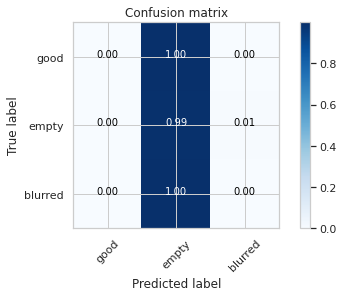

In [29]:
plot_confusion_matrix(confusion_matrix,['good','empty','blurred'], normalize = True)